In [19]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
%matplotlib inline


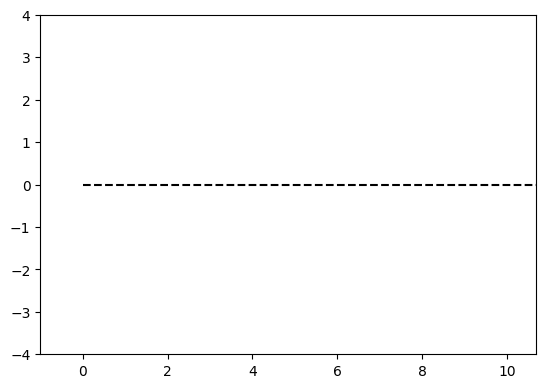

In [25]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

# -----------------------
# 1. Ellipse definition
# -----------------------
# We'll consider an ellipse parameterized by t in [0, 2*pi]:
#   x_local(t) = a cos(t)
#   y_local(t) = b sin(t)
# with the center at the origin in "local" coordinates.

a = 2.0  # semi-major axis
b = 1.0  # semi-minor axis

# Number of points to represent the ellipse boundary when drawing
N_ELLIPSE = 300
theta_ellipse = np.linspace(0, 2*np.pi, N_ELLIPSE)
x_ellipse_local = a * np.cos(theta_ellipse)
y_ellipse_local = b * np.sin(theta_ellipse)

# -------------------------------------------------------
# 2. Numerical arc-length function S(t) along the ellipse
# -------------------------------------------------------
# For the rolling contact to be "without slipping", the distance
# traveled by the contact point on the flat line equals the arc
# length traveled along the perimeter of the ellipse.
#
# We'll discretize t from 0 to 2*pi in many small steps, compute
# incremental distances, and build up an array S(t).

def ellipse_xy(t):
    """Return the (x,y) coordinates in local ellipse frame for parameter t."""
    return a*np.cos(t), b*np.sin(t)

def ellipse_xy_prime(t):
    """Return the derivatives (dx/dt, dy/dt)."""
    return -a*np.sin(t), b*np.cos(t)

# We'll build a lookup for arc length S(t) at discrete points
t_fine = np.linspace(0, 2*np.pi, 2000)  # fine sampling to get good resolution
x_fine, y_fine = ellipse_xy(t_fine)
dx_fine, dy_fine = ellipse_xy_prime(t_fine)
ds_fine = np.sqrt(dx_fine**2 + dy_fine**2)  # differential arc length
S_fine = np.cumsum(ds_fine)*(t_fine[1] - t_fine[0])  # naive trapezoid approx
# More accurate: we could do a trapezoidal rule integral, but
# for demonstration, this is typically sufficient at high resolution.

# Normalize so that S_fine[0] = 0 exactly
S_fine -= S_fine[0]
# The total perimeter is approximately
perimeter = S_fine[-1]

# A convenient helper to get S(t) from 0 to t by looking up in the table:
# We'll do it by direct index since t_fine is uniform in [0, 2*pi].
def S_of_t(t):
    """Return the arc length from t=0 up to t, using the precomputed array."""
    # Wrap t into [0, 2*pi] just in case
    t_mod = np.mod(t, 2*np.pi)
    # Fraction along the array:
    frac = t_mod / (2*np.pi)
    idx = frac * (len(t_fine) - 1)
    # Linear interpolation between integer indices
    i0 = int(idx)
    i1 = min(i0+1, len(t_fine)-1)
    w = idx - i0
    return (1.0 - w)*S_fine[i0] + w*S_fine[i1]

# ---------------------------------------------------------
# 3. Rolling condition => contact point's x = arc length S(t)
# ---------------------------------------------------------
# We define the "contact parameter" as t_contact in [0, 2*pi].
# The contact point on the ellipse is X_local = a cos(t_contact), Y_local = b sin(t_contact).
# If the ellipse "rolls" to parameter t_contact, the horizontal distance
# traveled (the x of the contact point on the line) = S_of_t(t_contact).

# ----------------------------------------
# 4. Orientation: tangent must be flat
# ----------------------------------------
# The slope of tangent in local coords at t_contact is given by
#   dy'/dx' = (dy/dt_contact) / (dx/dt_contact).
# Then the angle of that tangent wrt x'-axis is
#   tangent_angle = arctan2(dy'/dt_contact, dx'/dt_contact).
# If we want this tangent to be horizontal in the world frame,
# the ellipse must be rotated by -tangent_angle.
# So the global rotation of the ellipse alpha(t_contact) = -tangent_angle.

def tangent_angle(t):
    dx, dy = ellipse_xy_prime(t)
    return np.arctan2(dy, dx)

# -------------------------------------
# 5. Build arrays for the rolling motion
# -------------------------------------
N_FRAMES = 200  # number of frames for the animation
t_vals = np.linspace(0, 2*np.pi, N_FRAMES)

# We'll store the center of the ellipse for each step
center_x = np.zeros(N_FRAMES)
center_y = np.zeros(N_FRAMES)

for i, t_c in enumerate(t_vals):
    # Contact point in global coords is (S_of_t(t_c), 0)
    contact_x = S_of_t(t_c)
    contact_y = 0.0

    # Rotation needed so the tangent is horizontal
    alpha = -tangent_angle(t_c)

    # In the local ellipse frame, the contact point is (x_c, y_c) = (a cos(t_c), b sin(t_c))
    x_c_local, y_c_local = ellipse_xy(t_c)

    # The center is contact_point_global - R(alpha)*(x_c_local, y_c_local)
    # Because in local coords the center is (0,0), while the contact point is (x_c_local, y_c_local).
    # We'll build the 2D rotation matrix for alpha:
    cosA, sinA = np.cos(alpha), np.sin(alpha)
    # R(alpha) * (vx, vy) = (cosA*vx - sinA*vy, sinA*vx + cosA*vy)
    # so we want to subtract that from (contact_x, contact_y).
    cxx = cosA*x_c_local - sinA*y_c_local
    cyy = sinA*x_c_local + cosA*y_c_local

    center_x[i] = contact_x - cxx
    center_y[i] = contact_y - cyy

# -------------------------------------
# 6. Animation with matplotlib
# -------------------------------------
fig, ax = plt.subplots()
ax.set_aspect('equal', adjustable='box')
ax.set_xlim(-1, perimeter + 1)
ax.set_ylim(-2*a, 2*a)  # just enough room for the ellipse path

# We'll keep two main artists:
#  (1) The rolling ellipse (as a line plot)
#  (2) The trace of the center
ellipse_line, = ax.plot([], [], lw=2)
center_trace, = ax.plot([], [], lw=1, marker='o', ms=4)
# We can also show the ground line
ax.plot([0, perimeter+5], [0, 0], 'k--')  # ground

def init():
    ellipse_line.set_data([], [])
    center_trace.set_data([], [])
    return ellipse_line, center_trace

def update(frame):
    # Current contact parameter
    t_c = t_vals[frame]
    # Current center
    cx = center_x[frame]
    cy = center_y[frame]

    # Rotation
    alpha = -tangent_angle(t_c)
    cosA, sinA = np.cos(alpha), np.sin(alpha)

    # Rotate ellipse boundary
    x_loc = a * np.cos(theta_ellipse)
    y_loc = b * np.sin(theta_ellipse)
    x_rot = cosA*x_loc - sinA*y_loc
    y_rot = sinA*x_loc + cosA*y_loc

    # Translate
    x_global = x_rot + cx
    y_global = y_rot + cy

    # Update ellipse artist
    ellipse_line.set_data(x_global, y_global)
    # Update center trace up to this frame
    center_trace.set_data(center_x[:frame+1], center_y[:frame+1])

    return ellipse_line, center_trace

ani = FuncAnimation(fig, update, frames=N_FRAMES,
                    init_func=init, blit=True, interval=50)

plt.show()
from IPython.display import HTML

# After creating the 'ani' object:
HTML(ani.to_jshtml())



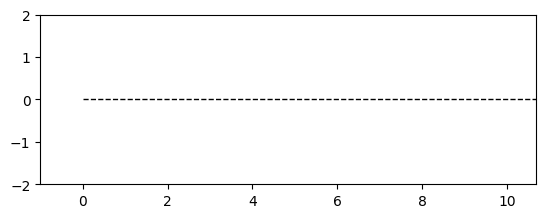

In [27]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter

# 1) Ellipse definition (semi-axes a, b).
a, b = 1, 2.0  # longer axis is initially horizontal

# 2) Parameter for ellipse boundary
def ellipse_xy(t):
    return a*np.cos(t), b*np.sin(t)

def ellipse_xy_prime(t):
    return -a*np.sin(t), b*np.cos(t)

# 3) Arc length S(t)
t_fine = np.linspace(0, 2*np.pi, 2001)
x_fine, y_fine = ellipse_xy(t_fine)
dx_fine, dy_fine = ellipse_xy_prime(t_fine)
ds = np.sqrt(dx_fine**2 + dy_fine**2)*(t_fine[1] - t_fine[0])
S_fine = np.cumsum(ds)
S_fine -= S_fine[0]  # Ensure S(0) = 0
perimeter = S_fine[-1]

def S_of_t(t):
    t_mod = np.mod(t, 2*np.pi)
    frac = t_mod / (2*np.pi)
    idx = frac * (len(t_fine) - 1)
    i0 = int(idx)
    i1 = min(i0+1, len(t_fine)-1)
    w = idx - i0
    return (1-w)*S_fine[i0] + w*S_fine[i1]

def tangent_angle(t):
    dx, dy = ellipse_xy_prime(t)
    return np.arctan2(dy, dx)

# 4) Precompute center trajectory
N_FRAMES = 200
t_vals = np.linspace(0, 2*np.pi, N_FRAMES)
center_x = np.zeros_like(t_vals)
center_y = np.zeros_like(t_vals)

for i, t_c in enumerate(t_vals):
    contact_x = S_of_t(t_c)
    contact_y = 0
    alpha = -tangent_angle(t_c)
    cosA, sinA = np.cos(alpha), np.sin(alpha)
    xc_loc, yc_loc = ellipse_xy(t_c)
    cx_local_rot = cosA*xc_loc - sinA*yc_loc
    cy_local_rot = sinA*xc_loc + cosA*yc_loc
    center_x[i] = contact_x - cx_local_rot
    center_y[i] = contact_y - cy_local_rot

# 5) Animation setup
fig, ax = plt.subplots()
ax.set_aspect('equal', adjustable='box')
ax.set_xlim(-1, perimeter+1)
ax.set_ylim(-2*a, 2*a)

ax.plot([0, perimeter+5], [0, 0], 'k--', lw=1)
ellipse_line, = ax.plot([], [], lw=2)
center_trace, = ax.plot([], [], 'o-', ms=4)

theta_draw = np.linspace(0, 2*np.pi, 300)

def init():
    ellipse_line.set_data([], [])
    center_trace.set_data([], [])
    return ellipse_line, center_trace

def update(frame):
    t_c = t_vals[frame]
    cx, cy = center_x[frame], center_y[frame]
    alpha = -tangent_angle(t_c)
    cosA, sinA = np.cos(alpha), np.sin(alpha)

    x_loc = a*np.cos(theta_draw)
    y_loc = b*np.sin(theta_draw)
    x_rot = cosA*x_loc - sinA*y_loc
    y_rot = sinA*x_loc + cosA*y_loc
    x_glob = x_rot + cx
    y_glob = y_rot + cy
    
    ellipse_line.set_data(x_glob, y_glob)
    center_trace.set_data(center_x[:frame+1], center_y[:frame+1])
    return ellipse_line, center_trace

ani = FuncAnimation(
    fig, update, frames=N_FRAMES, 
    init_func=init, blit=False, interval=50
)

# Save the animation as a GIF
gif_writer = PillowWriter(fps=20)
ani.save("rolling_oval.gif", writer=gif_writer)
HTML(ani.to_jshtml())

